In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")
import librosa

import torch
from transformers import AutoFeatureExtractor, AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

plt.ion()   # interactive mode

In [2]:
# Constants
AUDIORATE = 16000

### Define Dataset

In [3]:
class MMSERDataset(Dataset):
    """multi model ser dataset."""
    
        
    def __load_label__(self, cutmap_path):
        sheet_df = pd.DataFrame()
        for ses in range(1, 6):
            extractionmapPATH = cutmap_path + \
                str(ses)+'.xlsx'
            xl = pd.ExcelFile(extractionmapPATH)
            sheets = xl.sheet_names
            for sheet in sheets:
                sheet_df = pd.concat([sheet_df, xl.parse(sheet)])
        self.df_ = sheet_df
        
        # remove samples not agreed
        self.df_ = pd.merge(self.df_, self.df_text, on=["smp_id"])
        self.df_["emotion_id"] = self.df_["emotion"].map(self.emo2id)
        self.df_ = self.df_[self.df_["emotion_id"].notna()].reset_index(drop=True)
        self.df_["session"] = self.df_["smp_id"].apply(lambda x: x.split("_")[0])
        
    def __load_text__(self, text_path):
        self.df_text = pd.read_csv(text_path)
        pass
    
    def __load_audio__(self, fn_path):
        self.fn_list = list(self.df_["smp_id"])
        self.raw_list = []
        for fn in self.fn_list:
            self.raw_list.append(wavfile.read(os.path.join(fn_path, fn)+'.wav')[1])
    
    def __init__(self, 
                 fn_path, 
                 cutmap_path, 
                 text_path, 
                 emo2id):
        self.emo2id = emo2id
        self.__load_text__(text_path)
        self.__load_label__(cutmap_path)
        self.__load_audio__(fn_path)
        
    def __len__(self):
        return self.df_.shape[0]
    
    def __getitem__(self, idx):
        return {
            "sess": list(self.df_["session"])[idx],
            "fn": self.fn_list[idx],
            "audio": self.raw_list[idx],
            "text": list(self.df_["transcript"])[idx],
            "labels": list(self.df_["emotion_id"])[idx]
        }

### Dataset Init

In [4]:
emo2id_dict={
    "hap": 0,
    "ang": 1,
    "neu": 2,
    "sad": 3,
    "exc": 0,
       }

mmser_ds = MMSERDataset(fn_path = "E:/datasets/preprocessed/spectrogram/raw", 
                        cutmap_path = 'E:/datasets/preprocessed/extractionmap/cut_extractionmap', 
                        text_path = "E:/datasets/preprocessed/transcipt/transcript.csv", emo2id=emo2id_dict)


{'sess': ['Ses01F', 'Ses01F'], 'fn': ['Ses01F_impro02_F013', 'Ses01F_impro02_M011'], 'audio': [array([-18, -11,   2, ..., -44, -58, -52], dtype=int16), array([  6,  -3, -12, ..., -26, -41, -48], dtype=int16)], 'text': ["You'll videotape everything, yeah?", 'Yeah.'], 'labels': [3.0, 3.0]}
5531
emotion_id
2.0    1708
0.0    1636
1.0    1103
3.0    1084
Name: count, dtype: int64


<Axes: ylabel='count'>

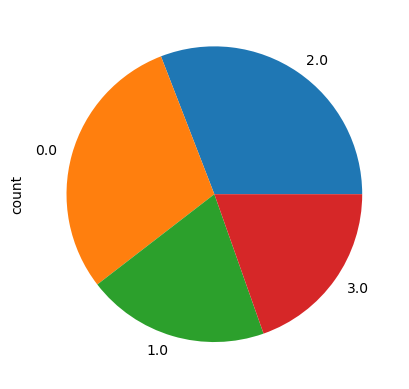

In [5]:
print(mmser_ds[22:24])
print(len(mmser_ds))
print(mmser_ds.df_["emotion_id"].value_counts())
mmser_ds.df_["emotion_id"].value_counts().plot(kind="pie")

### Save Dataset

In [8]:
torch.save(mmser_ds, "E:/datasets/preprocessed/dataset/mmser_ds.pt")

In [9]:
mmser_ds[0]

{'sess': 'Ses01F',
 'fn': 'Ses01F_impro01_F000',
 'audio': array([-130, -176, -263, ..., -124,  -98,  -47], dtype=int16),
 'text': 'Excuse me.',
 'labels': 2.0}